In [1]:
import pandas as pd
import numpy as np
import sqlite3
from rubin_sim.maf import generate_kn_pop_slicer
import rubin_sim.maf as maf

from scipy.spatial import cKDTree as kdTree
from rubin_scheduler.utils.coordinate_transformations import _xyz_from_ra_dec

import rubin_sim.maf as maf
import os

In [2]:
# Let's see if we can do a much faster check of which generated objects we need to check for
# how well they are observed

In [3]:
kne_slicer = generate_kn_pop_slicer(n_events=500000)

In [4]:
kne_slicer.slice_points["peak_time"]  # units of days.

array([2173.91318304, 1332.58228858,   20.62638896, ..., 1827.22905135,
       2093.82474429, 3204.5241441 ])

In [5]:
kne_slicer.slice_points["peak_time"].shape

(500000,)

In [6]:
kne_slicer.slice_points

{'sid': array([     0,      1,      2, ..., 499997, 499998, 499999]),
 'ra': array([2.35330497, 5.97351416, 4.59925358, ..., 3.06456674, 4.17823549,
        3.93746804]),
 'dec': array([ 0.41345954, -0.0189961 , -0.29201545, ...,  0.16459826,
         0.14314585, -1.03311228]),
 'gall': array([3.54246772, 1.21037978, 0.1572541 , ..., 4.4858032 , 0.32468224,
        5.56782955]),
 'galb': array([ 0.6621124 , -0.88601111,  0.15159586, ...,  1.15077657,
         0.73557261, -0.00825333]),
 'peak_time': array([2173.91318304, 1332.58228858,   20.62638896, ..., 1827.22905135,
        2093.82474429, 3204.5241441 ]),
 'file_indx': array([221, 130,  61, ..., 210, 104, 213]),
 'distance': array([169.46180224, 221.70672592, 267.9681377 , ..., 113.21786353,
        267.62848259, 149.83904915])}

In [7]:
con = sqlite3.connect("baseline_v4.0_10yrs.db")
observations = pd.read_sql("select fieldRA,fieldDec,observationStartMJD from observations;", con)
con.close()

In [8]:
# XXX---if I norm the distance to 1, and the time to 1, does that mean
# my search radium should be 1, or sqrt(2), or something else?

def _build_temporal_tree(ra, dec, mjd, leafsize=100, ang_norm=np.radians(1.75), temporal_norm=20., mjd0=None):
    if mjd0 is None:
        mjd0 = np.min(mjd)
    dist_norm = 2.*np.sin(ang_norm/2.)
    x,y,z = _xyz_from_ra_dec(ra, dec) / dist_norm

    time = (mjd - mjd0) / temporal_norm

    data = list(zip(x,y,z,time))
    tree = kdTree(data, leafsize=leafsize, balanced_tree=False, compact_nodes=False)

    return tree


In [9]:
obs_tree = _build_temporal_tree(np.radians(observations["fieldRA"]),
                                np.radians(observations["fieldDec"]),
                                observations["observationStartMJD"])

In [10]:
kne_tree = _build_temporal_tree(kne_slicer.slice_points["ra"], 
                                kne_slicer.slice_points["dec"],
                                kne_slicer.slice_points["peak_time"],
                                mjd0=0)

In [11]:
ack = kne_tree.query_ball_tree(obs_tree, 1.)

In [12]:
ack

[[],
 [735636, 735663],
 [14061, 14112, 15160, 15211],
 [],
 [],
 [1060272, 1060295, 1065839, 1065895, 1066895, 1067781, 1067804, 1068686],
 [],
 [],
 [],
 [],
 [],
 [712300,
  712351,
  717888,
  717939,
  719550,
  719552,
  719601,
  719603,
  721352,
  721403,
  724232,
  724283],
 [1621501],
 [],
 [],
 [1772570,
  1772621,
  1773315,
  1773366,
  1774187,
  1774188,
  1774238,
  1774239,
  1776440,
  1776491,
  1777140,
  1777162,
  1778147,
  1778198,
  1778843,
  1778894,
  1779696,
  1779747],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [1984014,
  1984065,
  1985029,
  1985080,
  1987388,
  1987439,
  1989073,
  1989117,
  1995288,
  1995339,
  1998227,
  1998278,
  1999770],
 [742473, 742524],
 [],
 [],
 [],
 [],
 [1488782, 1488833, 1489873, 1491681, 1491732, 1501663, 1501714],
 [1258958, 1259009],
 [],
 [],
 [],
 [631030, 633302],
 [],
 [1112189,
  1112212,
  1112238,
  1112261,
  1112904,
  1112927,
  1113626,
  1113651,
  1115367,
  1115368,
  1116591,
  1116595,
  1116642,
  1116

In [13]:
ack[551]

[]

In [14]:
# don't bother saving unlesss we have at least N points
min_num = 2
indx = np.array([i for i,sub in enumerate(ack) if len(sub) >= min_num])


In [15]:
len(indx)

171348

In [16]:
# Try running on just the sub

sub_slicer = maf.UserPointsSlicer(np.degrees(kne_slicer.slice_points["ra"][indx]),
                                  np.degrees(kne_slicer.slice_points["dec"][indx]), lat_lon_deg=True, badval=0)
sub_slicer.slice_points["peak_time"] = kne_slicer.slice_points["peak_time"][indx]
sub_slicer.slice_points["file_indx"] = kne_slicer.slice_points["file_indx"][indx]
sub_slicer.slice_points["distance"] = kne_slicer.slice_points["distance"][indx]


In [17]:
baseline_file = 'baseline_v4.0_10yrs.db'
name = os.path.basename(baseline_file).replace('.db','')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)

In [18]:
bundle_list = []

metric = maf.KNePopMetric()
sql = ''
slicer = sub_slicer
summary_metrics = [maf.SumMetric()]

bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name, summary_metrics=summary_metrics))

/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:665: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn("Cannot plot object metric values with this plotter.")
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:153: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:153: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:153: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:153: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:153: UserWarning: Optimal bin calculation tried to make inf 

sum= 15745.0
14min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


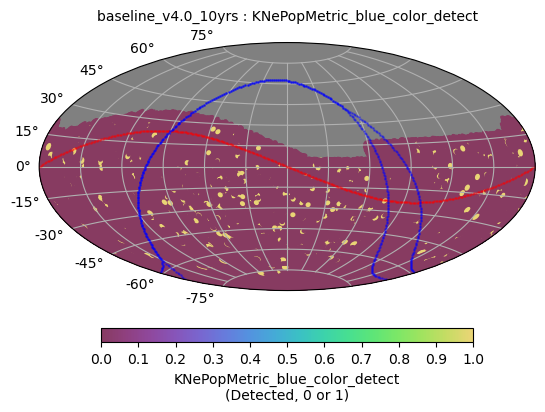

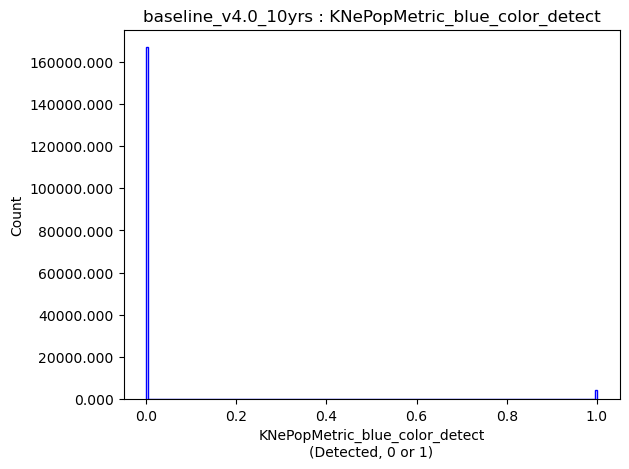

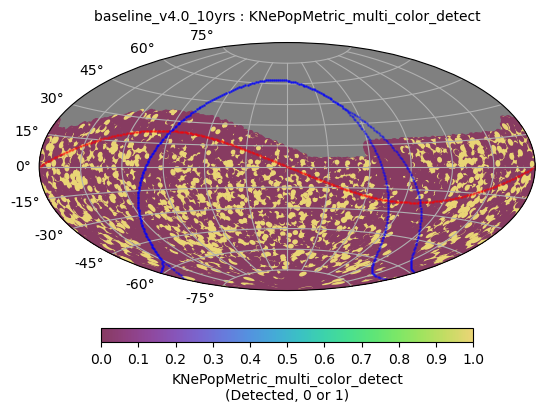

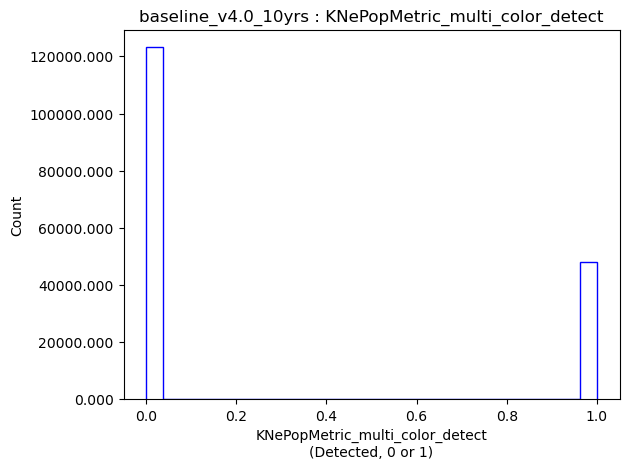

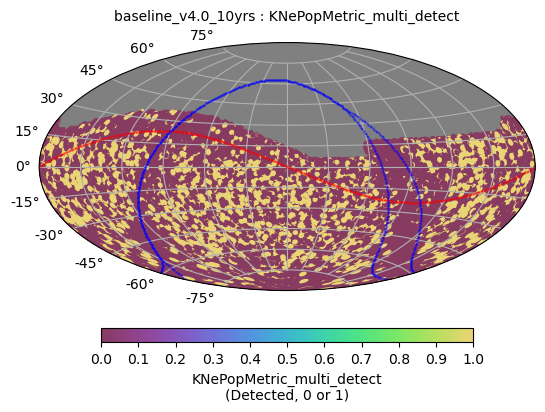

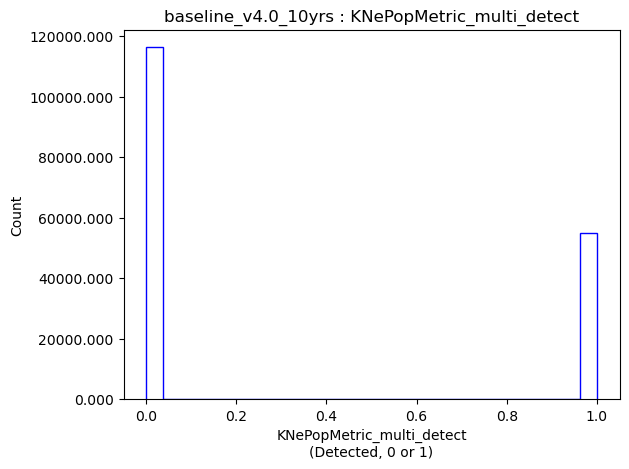

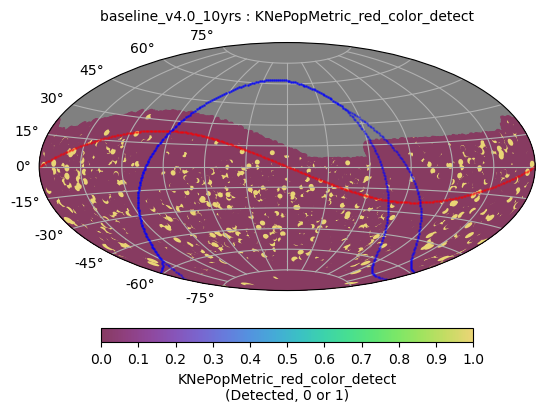

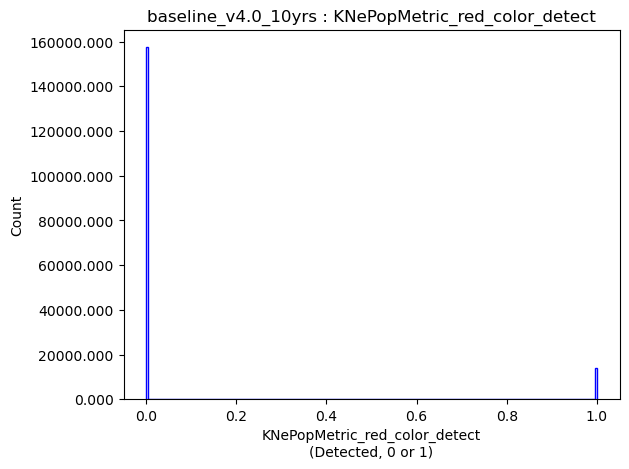

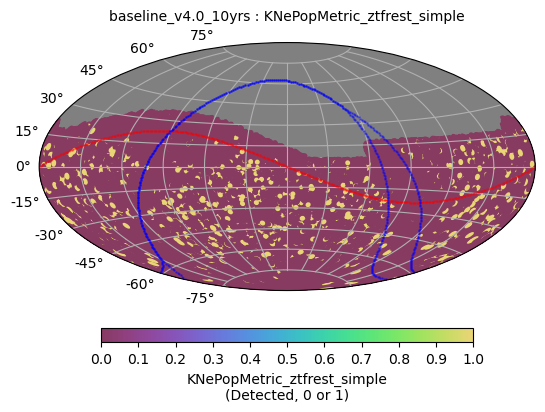

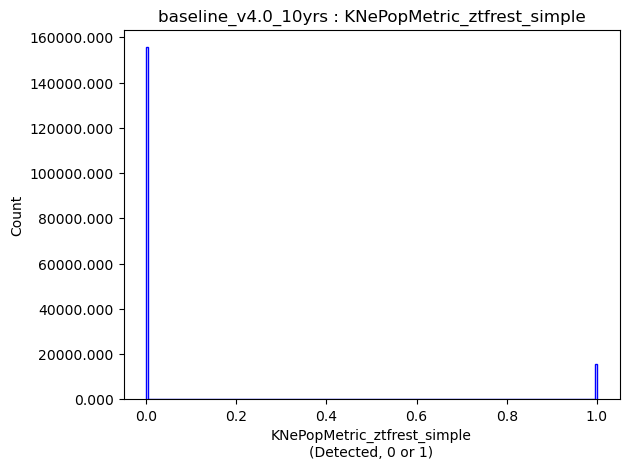

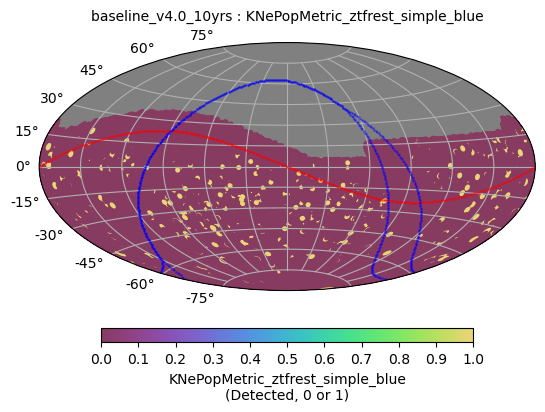

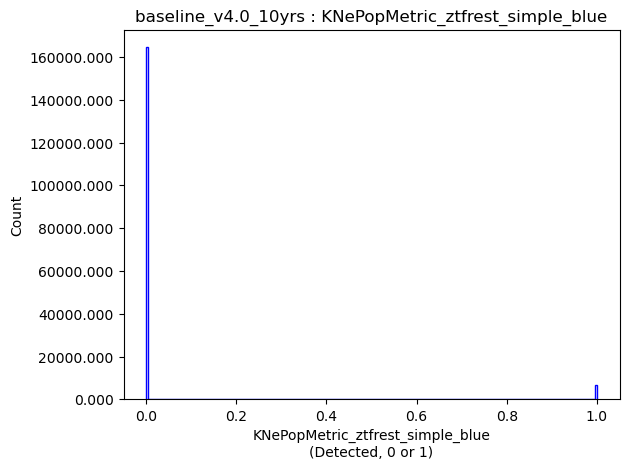

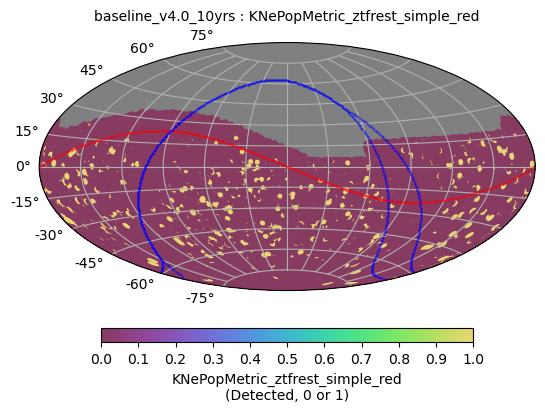

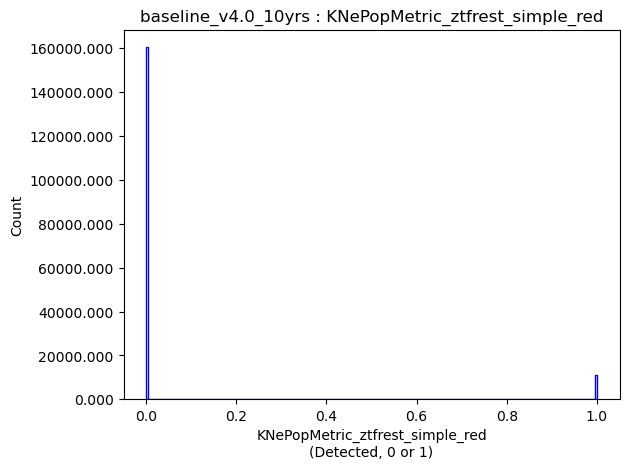

In [19]:
%%timeit -r 1 -n 1
bd_sub = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg_sub = maf.metricBundles.MetricBundleGroup(bd_sub, baseline_file, out_dir=out_dir, results_db=results_db)
bg_sub.run_all()
bg_sub.plot_all(closefigs=False)

print('sum=', bd_sub['KNePopMetric_ztfrest_simple'].metric_values.sum())


In [20]:
%%timeit -r 1 -n 1
bd_sub = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg_sub = maf.metricBundles.MetricBundleGroup(bd_sub, baseline_file, out_dir=out_dir, results_db=results_db)
bg_sub.run_all()
#bg_sub.plot_all(closefigs=False)

print('sum=', bd_sub['KNePopMetric_ztfrest_simple'].metric_values.sum())


sum= 15745.0
2min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [21]:
bundle_list = []

metric = maf.KNePopMetric()
sql = ''
slicer = kne_slicer

summary_metrics = [maf.SumMetric()]

bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name, summary_metrics=summary_metrics))


In [22]:
%%timeit -r 1 -n 1
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()
#bg.plot_all(closefigs=False)
print('sum=', bd['KNePopMetric_ztfrest_simple'].metric_values.sum())


sum= 15755.0
3min 41s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plot_handler.py:665: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn("Cannot plot object metric values with this plotter.")
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:153: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:153: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:153: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:153: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:153: UserWarning: Optimal bin calculation tried to make inf 

sum= 15755.0
27min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


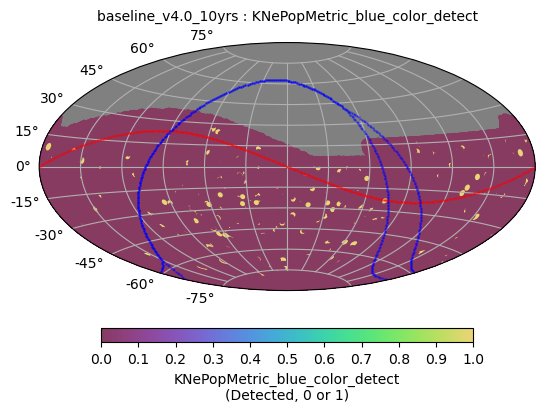

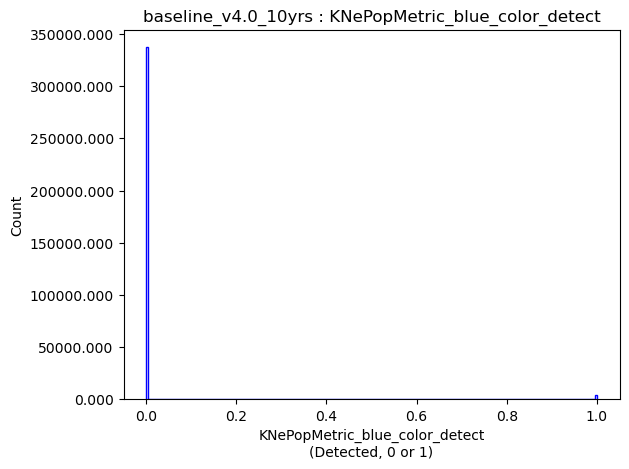

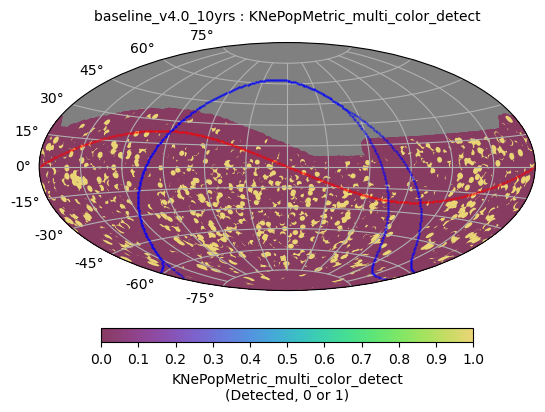

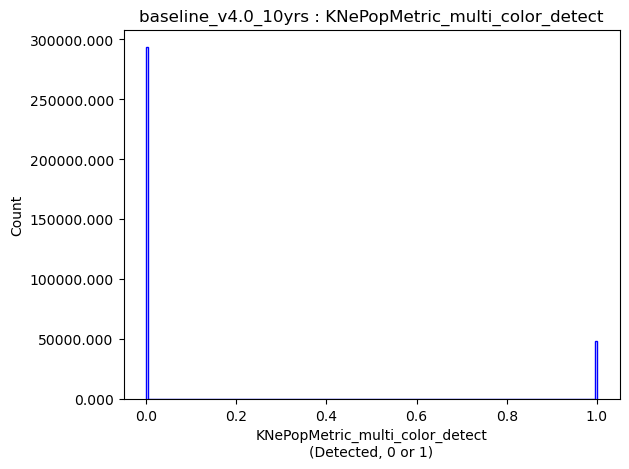

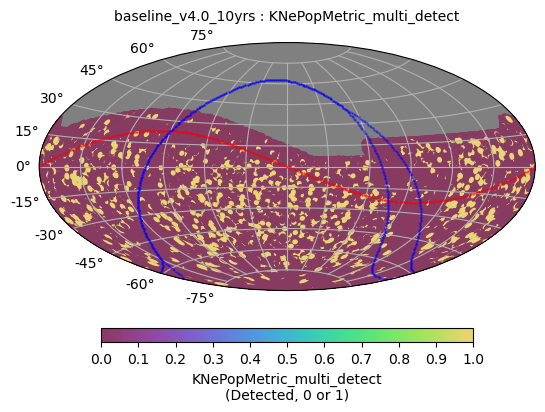

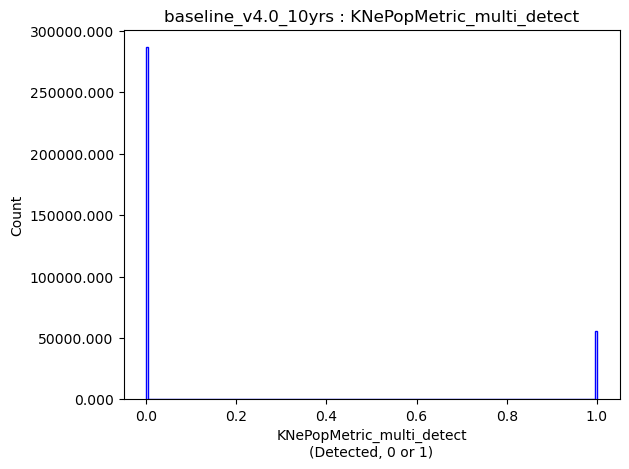

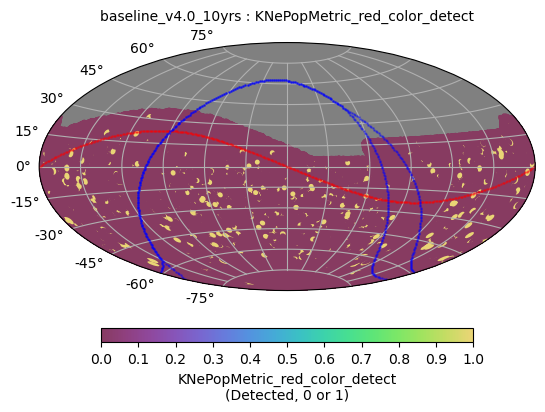

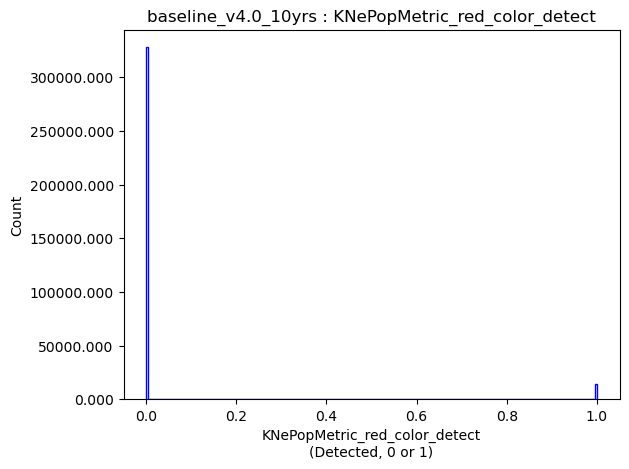

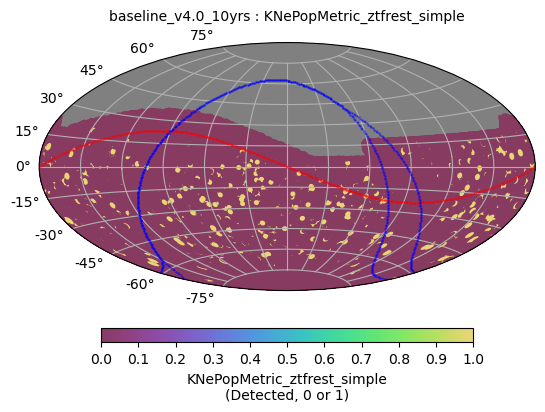

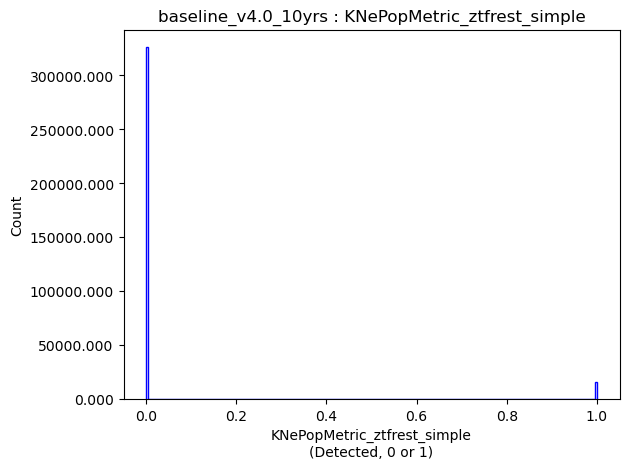

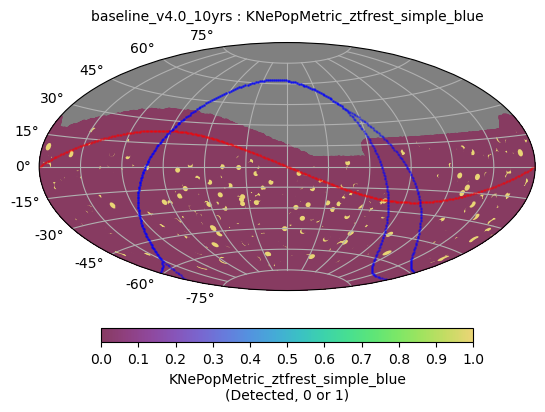

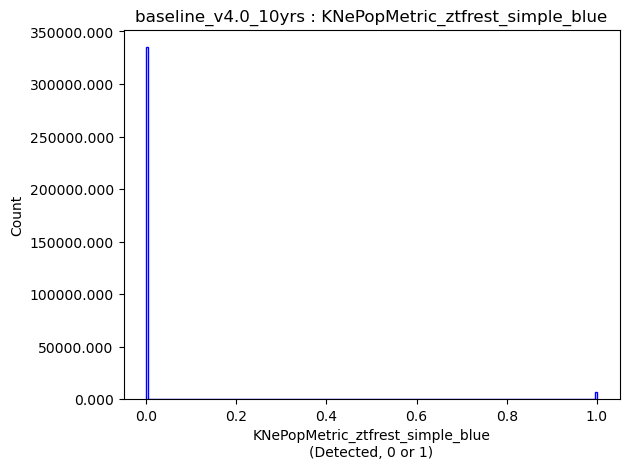

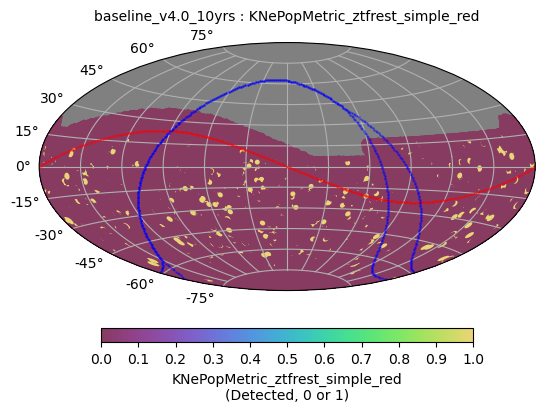

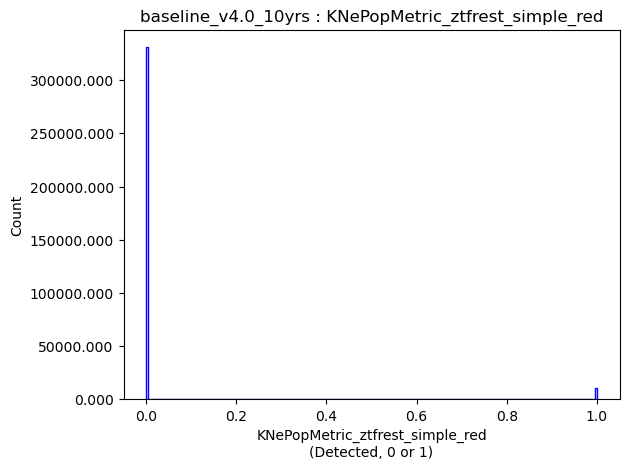

In [23]:
%%timeit -r 1 -n 1
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()
bg.plot_all(closefigs=False)
print('sum=', bd['KNePopMetric_ztfrest_simple'].metric_values.sum())
